### Tamagotchi POMCP
pam o.p. 2018
Pomagotchi (Partially observable tamagotchi)
And POMCP solution method (MCTS in PO framework)

In [2]:
# imports
from random import randint
import numpy as np
import random
import datetime # for limiting calculation to wall clock time
import math
import copy
import matplotlib.pyplot as plt


In [4]:
# tamagotchi class adapted from https://github.com/bitterfly/tamagotchi/blob/master/tamagotchi/core/tamagotchi.py

class Tamagotchi:
    def __init__(self):
        self.stats = {"food": 100, "happiness": 100, "hygiene": 100,
                 "health": 100, "energy": 100}
        self.is_sleeping = False
        self.is_dead = False
        self.is_playing = False
        self.is_sick = False
        self.number_of_poo = 0
        self.money = 0
        self.time = 0
        self.in_store = False

    #Makes sure the statistic isn't below 0 or above 100
    def constrain(self, value):
        value = min(100, value)
        value = max(0, value)
        return value

    #Constrains all the stats
    def constrain_stats(self):
        for statistic, value in self.stats.items():
            self.stats[statistic] = self.constrain(value)

    #Takes a dictionary with statistics and adds each value
    #to the tamagotchi statistics
    def apply(self, item):
#         for statistic, value in self.stats.items():
#             self.stats[statistic] += item[statistic]
        self.stats[item['stats']] += item['effect']
        self.constrain_stats()

#     #Takes a statistic and decreases it to zero in "full hours" time
    def decrease_to_minimum(self, statistic, full_hours, time_given):
        self.stats[statistic] -= 2 * np.ceil( (time_given * 10) / (full_hours * 36) ) 
#     def decrease_to_minimum(self, statistic, full_hours, time_given):
#         self.stats[statistic] -= int(full_hours/2)

#     #Takes a statistic and increases it to max in "full hours" time
    def increase_to_maximum(self, statistic, full_hours, time_given):
        self.stats[statistic] += 2 * np.ceil( (time_given * 10) / (full_hours * 36) ) 
#     def increase_to_maximum(self, statistic, full_hours, time_given):
#         self.stats[statistic] += int(full_hours)

    #Generates random sickness and poo
    def random_event(self):
        if (not self.is_playing and not self.is_sleeping):
            random_number = randint(0, 600)
            if random_number == 0:
                self.is_sick = True
            if random_number == 1:
                self.number_of_poo = min (self.number_of_poo + 1, 4)

    #Used in mainwindow - removes sickness
    def cure(self):
        self.is_sick = False

    #The function witch decreases all the stats every second
    #or is called when tamagotchi is sleeping
    def second_pass(self, seconds=1):
        "Докато спиш всички статове падат за 8 часа, освен сънят, който се възстановява"
        "As long as you sleep, all the stats fall for 8 hours, except for the sleep that is recovering"
        self.time += 1 
        
        # let's see what happens if make it a finite problem (though should really be same w discounted futures but...)
        if self.time >= 1000:
            self.is_dead = True
        
        if self.is_sleeping:
            self.increase_to_maximum("energy", 3, seconds)
            self.decrease_to_minimum("happiness", 20, seconds)
            self.decrease_to_minimum("hygiene", (20 + 2*self.number_of_poo), seconds)
            self.decrease_to_minimum("food", 20, seconds)
            
            # earn money while asleep
            if self.is_playing:
                self.money += 4*seconds # pam added
            
            if self.stats["energy"] > 50:
                self.is_sleeping = False
        else:
            "Докато играеш, повечето статистики падат по-бързо."
            "As you play, most stats fall faster"
            if self.is_playing:
                self.decrease_to_minimum("energy", 3, seconds)
                self.decrease_to_minimum("hygiene", 3, seconds)
                self.decrease_to_minimum("food", 6, seconds)
                self.increase_to_maximum("happiness", 1, seconds)
                self.money += 4*seconds # pam added
            else:
                self.decrease_to_minimum("energy", 4, seconds)
                self.decrease_to_minimum("hygiene", 4 / (self.number_of_poo + 1), seconds)
                self.decrease_to_minimum("food", 8, seconds)
                self.decrease_to_minimum("happiness", 4, seconds)

        if (self.stats["happiness"] <= 50 or
               self.stats["hygiene"] <= 50):
                self.is_sick = True
                
        if self.is_sick:
            self.decrease_to_minimum("health", 3, seconds)

        self.constrain_stats()

        self.random_event()

        if (self.stats["food"] == 0 or self.stats["health"] == 0):
            self.is_dead = True
        
        #add (?) that if energy is <=20 then goes to sleep
        if self.stats["energy"] <=20:
            self.is_sleeping = True

    #The function is called when an item is chosen and
    #applies its statistics
    def buy_item(self, item):
        self.apply(item)
        self.money -= item["price"]
        return self
    
    # so that tuple(tamagotchi) can be called, make tamagotchi iterable
    def __iter__(self):
        traits = [tuple(self.stats.items()),
                 self.is_sleeping,
                 self.is_dead,
                 self.is_playing,
                 self.is_sick,
                 self.number_of_poo,
                 self.money,
                 self.time,
                 self.in_store]
        for i in range(len(traits)):
            yield traits[i]
                
    
    def print_tama(self):
        print("Time:",self.time," seconds elapsed")
        if self.is_dead:
            print("Tama is dead!")
    
        print("TAMA STATS: ", self.stats)
        if self.is_sleeping:
            print("Tama is asleep.")
        else:
            print("Tama is awake.")
            if self.is_playing:
                print("Tama is playing.")
            if self.is_sick:
                print("Tama is sick.")
        print("Number of poo:",self.number_of_poo)
        print("Money:",self.money)
        if self.in_store:
            print("You're in the store, so you can buy an item if you want.")
        else:
            print("You're not in the store, so you can play, do nothing, or travel to the store.")
                
        print("\n")
        
    

In [5]:
# game class:
# defines transition probs, legal actions, reward probs, observation probs 
class Tamagotchi_Game():
    def __init__(self):
#         self.tamagotchi = tamagotchi
        self.time_passing = True
        self.observation_prob = 0.8
    
    # start game 
#     def start(self,state):
#         self.time_passing = True
#         return state
        
    # not used, but would be useful for a human playing the game to take breaks
#     def pause(self):
#         self.time_passing = False
#         return self.tamagotchi
        
    # given a tuple tamagotchi "state" and action "action", what would the next tama state be?
    # this contains the transition function for the MDP
    def next_state(self, tupstate, action):
        
        state = unpack(tupstate)   
        
        free_acts = ['nothing','check-happy','check-energy',
                     'check-food','check-health','check-hygiene',
                     'check-asleep','check-playing','check-money',
                     'check-sick','check-instore','check-numpoo']
        
        if action in free_acts and not action == 'nothing':
#             state.is_playing = False
            state.second_pass()
            return tuple(state) # one second passes nothing else happens
          
        if state.in_store:
            state.is_playing = False
            state.second_pass() # does this need to be state.second_pass()

            if action == 'nothing': # leave the store
                state.in_store = False
                return tuple(state)
            elif action == 'coffee':
                return tuple(state.buy_item({"stats":"energy","price":3,"effect":8}))
            elif action == 'snack':
                return tuple(state.buy_item({"stats":"food","price":3,"effect":8}))
            elif action == 'clean':
                state.number_of_poo =0
                return tuple(state.buy_item({"stats":"hygiene","price":5,"effect":10}))
            elif action == 'medicine':
                state.cure()
                return tuple(state.buy_item({"stats":"health","price":8,"effect":15}))
            else:
                raise Exception('Invalid action while in store')

        if action == 'play':
            state.is_playing = True
            state.second_pass()
            # if the tama is sleeping, playing won't earn any money - tama needs to be awake
            return tuple(state)

        # "walk" to the store (takes one turn)
        if action == 'store':
            state.is_playing = False
            state.in_store = True
            state.second_pass()
            return tuple(state)

        if action == 'nothing':
            state.is_playing = False
            state.second_pass()
            return tuple(state)
       
    # observation function for the POMDP
    # if other actions provide observations, put that info in here, so this fxn looks more
    # like next_state (e.g., if action = "snack" then observe hunger level)
    def observation(self, tupletama, action):        
        stats = dict(tupletama[0])
        if action == 'check-happy':
            return ['happiness', stats['happiness']]
        elif action == 'check-energy':
            return ['energy', stats['energy']]
        elif action == 'check-food':
            return ['food', stats['food']]
        elif action == 'check-health':
            return ['health', stats['health']]
        elif action == 'check-hygiene':
            return ['hygiene', stats['hygiene']]
        elif action == 'check-asleep':
            return [1,tupletama[1]]
        elif action == 'check-playing':
            return [3,tupletama[3]]
        elif action == 'check-sick':
            return [4,tupletama[4]]
        elif action == 'check-money':
            return [6,tupletama[6]]
        elif action == 'check-instore':
            return [8,tupletama[8]]
        elif action == 'check-numpoo':
            return [5,tupletama[5]]
        else:
            return []

        
    # Take a sequence of game states representing the full game history, and return the full list
    # of actions that are legal actions
    def legal_actions(self, state): 
        # this method is important for MDPs/games where the actions might change based on the game state
        # for instance, in checkers, if player put a piece on square A4, no other piece can move to A4
        
        # get object version of most recent tamagotchi state
#         tama = self.unpack(state_history[-1])
#         tupletama = state_history[-1] # avoid unpacking bc it takes a long time to do
        tupletama = state
        
        # actions you can take whenever wherever
        free_acts = ['nothing','check-happy','check-energy',
                     'check-food','check-health','check-hygiene',
                     'check-asleep','check-playing','check-money',
                     'check-sick','check-instore','check-numpoo']
        
        if not tupletama[2]: # not dead
            if tupletama[8]: # in store
                if tupletama[6] >= 8:
                    return ['coffee','snack','clean'] + free_acts
                elif tupletama[6] >= 5:
                    return ['coffee','snack','clean'] + free_acts
                elif tupletama[6] >= 3:
                    return ['coffee','snack'] + free_acts
                else: # too poor to shop :(
                    return free_acts
            else: 
                return ['play','store'] + free_acts
        else:
            return []
    
    # Should this be the length of state_history (how long tama alive for)? or is it trial by trial rwd?
    def reward(self, tupletama):
#         tupletama = state_history[-1]
        
        done = False
        if tupletama[2]: # tama dead
            reward = tupletama[7] # you killed the tama :'( enjoy your MONEY
            done = True
        else:
            # reward is how long you kept the tama alive
            reward = tupletama[7] 

        return reward, done
    
    # GENERATOR MODEL OF TAMAGOTCHI GAME
    # returns next state, observation, and reward given an action taken in given state
    # takes tuple state
    def G_model(self,state,action):
        s = self.next_state(state,action)
        obs = self.observation(state,action)
        rwd,_ = self.reward(state) # note that this should be more like immediate reward of state, not long-term?
        return s, obs, rwd
    
    def unpack(self,tupletama):
        tama = Tamagotchi()
        tama.stats = dict(tupletama[0])
        tama.is_sleeping = tupletama[1]
        tama.is_dead = tupletama[2]
        tama.is_playing = tupletama[3]
        tama.is_sick = tupletama[4]
        tama.number_of_poo = tupletama[5]
        tama.money = tupletama[6]
        tama.time = tupletama[7]
        tama.in_store = tupletama[8]
        return tama

    

In [6]:
# Debug step!
# Double check that the tama works - if we manually take actions, do we end up where expected? 
# Then we will create the solver so that a robot can choose actions instead of us.

tama = Tamagotchi()
tama.print_tama()
game = Tamagotchi_Game()

s = game.next_state(tuple(tama),'play')
s = game.next_state(s,'play')
s = game.next_state(s,'store')
s = game.next_state(s,'clean')
s = game.next_state(s,'nothing')
tama = game.unpack(s)
tama.print_tama()

r,done = game.reward(s)
print(r)

Time: 0  seconds elapsed
TAMA STATS:  {'health': 100, 'energy': 100, 'happiness': 100, 'food': 100, 'hygiene': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.




NameError: name 'unpack' is not defined

In [7]:
#class adapted from github.com/cbarrick/POMCP-Blackjack

class SearchTree:
    def __init__(self, particles=[], action = None, visit=1, value=0, **kwargs): #, action = None
        self.particles=particles
        self.visit=visit
        self.value=value
        self.action=action
        self.children=[] # set() (when this was a set, could not index it - but set does have advantages too)
    
# #         assert kwargs.get('action') or kwargs.get('obs'), 'Node needs action or obs label'
#         if kwargs.get('action'):
#             self.action = kwargs.get('action')
#         if kwargs.get('obs'):
#             self.obs = kwargs.get('obs')
        
    def expand(self, legal_actions):
        for a in legal_actions:
            self.children.append(SearchTree(action=a))
        
    # upper confidence bound value for given node "child"
    def ucb(self, child):
#         print("self.visit=",self.visit," len of self.children=",len(self.children))
        logval = math.log(self.visit) #, len(self.children))
        div = logval / child.visit
        return math.sqrt(div)
    
    def isleaf(self):
        if len(self.children) == 0:
            return True
        else:
            return False
        
    def print_tree(self, level=0):
        print('\t' * level + repr(self.action) + ' val:' + repr(self.value) + ' visits:' + repr(self.visit))
        for child in self.children:
            child.print_tree(level+1)
        
    # I think this might be useful if i need to check the structure of the tree
#     # e.g. that all children of action nodes are observations and vice versa
#     def isaction(self):
#         if self.action:
#             return True
#         else:
#             return False  

In [8]:
# Initial state distribution
def sample_prior():
    s = Tamagotchi()
#     for statistic, value in s.stats.items():
#         s.stats[statistic] = int(np.random.normal(80,10))
#         s.constrain_stats()
    return tuple(s)

def unpack(tupletama):
    tama = Tamagotchi()
    tama.stats = dict(tupletama[0])
    tama.is_sleeping = tupletama[1]
    tama.is_dead = tupletama[2]
    tama.is_playing = tupletama[3]
    tama.is_sick = tupletama[4]
    tama.number_of_poo = tupletama[5]
    tama.money = tupletama[6]
    tama.time = tupletama[7]
    tama.in_store = tupletama[8]
    return tama

def keep_particle(part, real_obs):
    max_diff = 10
    
    if real_obs == []:
        return True
    else:
        if isinstance(real_obs[0], str): #one of the five vital stats
            pstats = dict(part[0])
            return abs(pstats[real_obs[0]] - real_obs[1]) < max_diff
#         for statistic, value in pstats.items():
#             if pstats[statistic] - ostats[statistic] > max_diff:
#                 return False
        else:
            return abs(part[real_obs[0]] == real_obs[1]) < max_diff
#     return True
    
def constrain(value):
    value = min(100, value)
    value = max(0, value)
    return value
    
# might need to include a keep_particle in here somewhere so that belief state
# doesn't keep particles with inconsistent state to observation (but i have limited
# the noise enough that shouldn't be a problem to add noise to existing accepted particles)
def new_particle(part):
    noise = [-2,-1,0,1,2] # add some artificial noise
    s = part
    stats = dict(s[0])
    for statistic, value in stats.items():
        stats[statistic] = constrain(stats[statistic] + random.choice(noise))
    return s

In [9]:
class POMCP(object):
    
    def __init__(self, 
                 game=Tamagotchi_Game(),
                 discount=0.8,
                 depth=0,
                 epsilon=1e-7,
                 explore=150,
                 n_particles=100,
                 reinvigoration=10, 
                 **kwargs):
        
        #         self.context = {}
        self.game = game
        self.discount = discount
        self.depth = depth
        self.epsilon = epsilon
        self.explore = explore
        self.n_particles = n_particles
        self.reinvigoration = reinvigoration
        self.G = game.G_model        
        # list of all possible actions
#         self.actions = kwargs.get('actions') 
        
        seconds = kwargs.get('time',30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.max_moves = kwargs.get('max_moves',200)
        
    # Particle filtering
    def update_belief(self,tree,obs):
        particles = [part for part in tree.particles if keep_particle(part,obs)]
        for _ in range(self.reinvigoration):
            particles.append(new_particle(random.choice(particles)))
        tree.particles = particles
        return tree
        
    # choose a move! "search" algorithm, which begins at a root of a search tree and decides the 
    # next optimal action given the recent real observation and legal actions at the current state
    def choose_move(self,obs,context,legal_actions):
        begin = datetime.datetime.utcnow()
        reinvig = False
        while (datetime.datetime.utcnow() - begin) < self.calculation_time:
            tree = context.get('pomcp_root')    
            if tree is None: # if we are at the root of the whole tree: no history
                tree = SearchTree()
                context['pomcp_root'] = tree
                context['full_tree'] = []
                # sample s from initial state dist
                tree.particles = [sample_prior() for _ in range(self.n_particles)]
                part = random.choice(tree.particles)
            if tree is not None and reinvig == False:
                particles = [part for part in tree.particles if keep_particle(part,obs)]
                if len(particles) == 0: # THIS PART IS BAD bc what if trying to reinvigorate at a late stage of game?
                    particles.append(sample_prior())
                for _ in range(self.reinvigoration):
                    particles.append(new_particle(random.choice(particles)))
                tree.particles = particles
                part = random.choice(tree.particles)
                reinvig = True
            
            self.simulate(part,tree,0)
        
        # greedily choose best action based on child action values
        children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
        child_vals = np.array([child.value for child in children])
        favechildren = np.argwhere(child_vals == np.amax(child_vals))
        child = children[random.choice(favechildren.flatten().tolist())]
        
        context['full_tree'].append(tree)
        context['pomcp_root'] = child 
        return child.action
        
    # update the values of the actions in the tree by best-first search, simulating actions
    # and their effects (rewards) using G 
    def simulate(self,part,tree,depth):
        # if we have simulated past the point of caring (past our discount horizon) or if tama is dead (state[2])
        if self.discount**depth < self.epsilon or depth >= self.max_moves or part[2]:
            return 0 # reward of these faraway futures is meaningless, nothing
        
        # get legal actions
        legal = self.game.legal_actions(part)
        
        # if the current history does not have a node in the search tree, e.g., tree has no child nodes,
        # then expand
        if len(tree.children) == 0:
            tree.expand(legal)
            return self.rollout(part,depth)
        
        # only one legal action
        if len(legal)==1:
            action = legal[0]
        else:
            # if current history does have a node, so we know the value of its action children,
            # use ucb to choose best action given current value fxns
            children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
            child_vals = np.array([child.value + self.explore * tree.ucb(child) for child in children])
            favechildren = np.argwhere(child_vals == np.amax(child_vals))
            child = children[random.choice(favechildren.flatten().tolist())]
        
            action = child.action
        
        next_state, next_obs, r = self.G(part,action)
        new_part = next_state #Particle.from_s(next_state)
        reward = r + self.discount * self.simulate(new_part, child, depth + 1) #self.discount * self.simulate(new_part, child, depth + 1)
        tree.particles.append(new_part)
        
        tree.visit += 1
        child.visit += 1
        child.value += (reward - child.value) / child.visit
        
        return reward
        
    # roll out to max moves initialize the value of a new node
    def rollout(self,state,depth):
        # if we have rolled out past the point of caring (past our discount horizon) or if tama is dead (state[2])
        if self.discount**depth < self.epsilon or depth >= self.max_moves or state[2]:
            return 0 # reward of these futures is meaningless, nothing
        
        legal = self.game.legal_actions(state)
        a = random.choice(legal) # random rollout policy
        
        next_state, obs, r = self.G(state,a)

        return r + self.discount * self.rollout(next_state, depth+1) #self.discount * self.rollout(next_state, depth+1)     
        

In [31]:
# Create a tamagotchi game and a POMCP agent (search tree)
realtama = Tamagotchi()
game = Tamagotchi_Game()
agent = POMCP(game, time = 1.)

In [32]:
# Check that the tree run simulations to choose the next action using the choose_move() method

print("INITIAL STATE: ")
realtama.print_tama() # initial tamagotchi state

obs = []
legal = game.legal_actions(tuple(realtama))
context = {}

action = agent.choose_move(obs,context,legal)
print("Taking action:", action)
state = game.next_state(tuple(realtama),action)
game.reward(state)

INITIAL STATE: 
Time: 0  seconds elapsed
TAMA STATS:  {'energy': 100, 'hygiene': 100, 'happiness': 100, 'food': 100, 'health': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Taking action: play


(1, False)

In [12]:
# Now, let the POMCP do its thing for several actions in a row (or until tama death)

# Initialize the tamagotchi
realtama = Tamagotchi()
game = Tamagotchi_Game()

print("INITIAL STATE: ")
realtama.print_tama() # initial tamagotchi state

agent = POMCP(game, time = 60., n_particles = 200, reinvigoration = 20)

action_seq = []
state = tuple(realtama)
obs = []
context = {}

# while len(action_seq) <= 1000 and not state[2]: # play for a certain amount of time (better rule?)
while not state[2]:
    legal = game.legal_actions(state)
    action = agent.choose_move(obs,context,legal)
    action_seq.append(action)
    print("Action %i: taking action %s."% (len(action_seq),action))
    
    obs = game.observation(state,action)
    if obs ==[]:
        print("No meaningful observation acquired.")
    else:
        print(obs)

    state = game.next_state(state,action)
    if len(action_seq) % 10 == 0:
        print("\nNumber of actions taken: ",len(action_seq))
        r,_ = game.reward(state)
        print("Reward so far: ",r)
        print("Tama state:")
        unpack(state).print_tama()
    
print("\nNumber of actions taken: ",len(action_seq))
r,_ = game.reward(state)
print("Reward so far: ",r)
print("Tama state:")
unpack(state).print_tama()
print("game over!")

INITIAL STATE: 
Time: 0  seconds elapsed
TAMA STATS:  {'health': 100, 'energy': 100, 'happiness': 100, 'food': 100, 'hygiene': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Action 1: taking action play.
No meaningful observation acquired.
Action 2: taking action check-sick.
[4, False]
Action 3: taking action check-health.
['health', 100]
Action 4: taking action check-numpoo.
[5, 0]
Action 5: taking action nothing.
No meaningful observation acquired.
Action 6: taking action check-hygiene.
['hygiene', 90.0]
Action 7: taking action check-money.
[6, 16]
Action 8: taking action store.
No meaningful observation acquired.
Action 9: taking action snack.
No meaningful observation acquired.
Action 10: taking action check-instore.
[8, True]

Number of actions taken:  10
Reward so far:  10
Tama state:
Time: 10  seconds elapsed
TAMA STATS:  {'happiness': 88.0, 'health': 100, 'energy': 80.0, 'food': 88.0, 'hygiene': 80.0

In [2]:
tree = context['pomcp_root']
# tree.print_tree()


NameError: name 'context' is not defined

In [1]:
root = context['full_tree'][0]
# root.print_tree()
# root.particles

NameError: name 'context' is not defined

In [34]:
all_act = set(action_seq)
for i in all_act:
    count = sum([1 for a in action_seq if a==i])
    print(i,':',count,'times')

check-energy : 4 times
check-playing : 9 times
check-food : 5 times
check-numpoo : 5 times
check-health : 3 times
play : 3 times
check-money : 7 times
check-asleep : 4 times
check-instore : 1 times
check-happy : 3 times
nothing : 4 times
check-hygiene : 5 times
store : 4 times
snack : 5 times
check-sick : 8 times


In [35]:
# let's observe what actions the tree chose!
print("\nNumber of actions taken: ",len(action_seq))
r,_ = game.reward(state)
print("Reward so far: ",r)
print("Tama state:")
unpack(state).print_tama()
print(action_seq)


Number of actions taken:  70
Reward so far:  70
Tama state:
Time: 70  seconds elapsed
Tama is dead!
TAMA STATS:  {'food': 0, 'hygiene': 0, 'happiness': 0, 'energy': 24.0, 'health': 8.0}
Tama is awake.
Tama is sick.
Number of poo: 0
Money: 29
You're in the store, so you can buy an item if you want.


['play', 'check-sick', 'check-numpoo', 'check-sick', 'check-numpoo', 'check-money', 'check-asleep', 'check-energy', 'store', 'snack', 'snack', 'snack', 'check-hygiene', 'check-playing', 'check-playing', 'check-hygiene', 'nothing', 'nothing', 'store', 'snack', 'nothing', 'check-sick', 'check-money', 'check-money', 'store', 'check-sick', 'check-numpoo', 'check-hygiene', 'nothing', 'check-numpoo', 'play', 'check-food', 'play', 'store', 'check-sick', 'check-money', 'check-food', 'check-asleep', 'check-sick', 'check-food', 'check-playing', 'check-happy', 'check-playing', 'check-hygiene', 'check-health', 'check-energy', 'check-playing', 'check-sick', 'check-money', 'check-health', 'check-energy'

In [7]:
# now let's compare the performance of different computation times (AND C)

storeobservations = []
storeactions = []
storerewards = []
cs = [1,1.4,2,5,10,50,100,150,200,250]

for c in cs:
    print("C = ", c)
    
    # Initialize the tamagotchi
    realtama = Tamagotchi()
    game = Tamagotchi_Game()

    print("INITIAL STATE: ")
    realtama.print_tama() # initial tamagotchi state

    agent = POMCP(game, time = 2, explore = c)

    action_seq = []
    obs_seq = []
    state = tuple(realtama)
    obs = []
    context = {}

    while len(action_seq) <= 1000 and not state[2]: # play for a certain amount of time (better rule?)

        legal = game.legal_actions(state)
        action = agent.choose_move(obs,context,legal)
        action_seq.append(action)
        print("Action %i: taking action %s."% (len(action_seq),action))

        obs = game.observation(state,action)
        obs_seq.append(obs)
        if obs ==[]:
            print("No meaningful observation acquired.")
        else:
            print(obs)

        state = game.next_state(state,action)
#         if len(action_seq) % 10 == 0:
#             print("\nNumber of actions taken: ",len(action_seq))
#             r,_ = game.reward(state)
#             print("Reward so far: ",r)
#             print("Tama state:")
#             unpack(state).print_tama()

    print("game over!")
    
    storeobservations.append([obs_seq])
    storeactions.append([action_seq])
    r,_ = game.reward(state)
    storerewards.append(r)
    unpack(state).print_tama()
    


C =  1
INITIAL STATE: 
Time: 0  seconds elapsed
TAMA STATS:  {'happiness': 100, 'hygiene': 100, 'health': 100, 'food': 100, 'energy': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Action 1: taking action check-happy.
['happiness', 100]
Action 2: taking action check-health.
['health', 100]
Action 3: taking action play.
No meaningful observation acquired.
Action 4: taking action play.
No meaningful observation acquired.
Action 5: taking action check-money.
[6, 8]
Action 6: taking action nothing.
No meaningful observation acquired.
Action 7: taking action play.
No meaningful observation acquired.
Action 8: taking action check-health.
['health', 100]
Action 9: taking action check-happy.
['happiness', 100]
Action 10: taking action check-money.
[6, 24]
Action 11: taking action check-asleep.
[1, False]
Action 12: taking action check-energy.
['energy', 78.0]
Action 13: taking action check-happy.
['happiness', 100]


Action 32: taking action check-hygiene.
['hygiene', 38.0]
Action 33: taking action check-money.
[6, 20]
Action 34: taking action check-numpoo.
[5, 0]
Action 35: taking action check-instore.
[8, False]
Action 36: taking action check-happy.
['happiness', 62.0]
Action 37: taking action check-instore.
[8, False]
Action 38: taking action play.
No meaningful observation acquired.
Action 39: taking action check-happy.
['happiness', 68.0]
Action 40: taking action check-money.
[6, 48]
Action 41: taking action check-food.
['food', 20.0]
Action 42: taking action check-numpoo.
[5, 0]
Action 43: taking action check-energy.
['energy', 24.0]
Action 44: taking action check-playing.
[3, True]
Action 45: taking action check-happy.
['happiness', 64.0]
Action 46: taking action check-food.
['food', 10.0]
Action 47: taking action check-energy.
['energy', 32.0]
Action 48: taking action nothing.
No meaningful observation acquired.
Action 49: taking action check-hygiene.
['hygiene', 4.0]
Action 50: taking acti

Action 7: taking action play.
No meaningful observation acquired.
Action 8: taking action check-food.
['food', 86.0]
Action 9: taking action check-energy.
['energy', 84.0]
Action 10: taking action check-happy.
['happiness', 94.0]
Action 11: taking action play.
No meaningful observation acquired.
Action 12: taking action check-playing.
[3, True]
Action 13: taking action check-energy.
['energy', 76.0]
Action 14: taking action check-happy.
['happiness', 100]
Action 15: taking action nothing.
No meaningful observation acquired.
Action 16: taking action check-money.
[6, 32]
Action 17: taking action store.
No meaningful observation acquired.
Action 18: taking action snack.
No meaningful observation acquired.
Action 19: taking action nothing.
No meaningful observation acquired.
Action 20: taking action check-energy.
['energy', 62.0]
Action 21: taking action check-energy.
['energy', 60.0]
Action 22: taking action check-hygiene.
['hygiene', 58.0]
Action 23: taking action check-playing.
[3, Fals

Action 21: taking action check-energy.
['energy', 60.0]
Action 22: taking action check-health.
['health', 100]
Action 23: taking action nothing.
No meaningful observation acquired.
Action 24: taking action play.
No meaningful observation acquired.
Action 25: taking action check-playing.
[3, True]
Action 26: taking action check-asleep.
[1, False]
Action 27: taking action check-asleep.
[1, False]
Action 28: taking action check-numpoo.
[5, 0]
Action 29: taking action check-instore.
[8, False]
Action 30: taking action check-instore.
[8, False]
Action 31: taking action nothing.
No meaningful observation acquired.
Action 32: taking action check-money.
[6, 29]
Action 33: taking action check-sick.
[4, True]
Action 34: taking action check-sick.
[4, True]
Action 35: taking action check-happy.
['happiness', 72.0]
Action 36: taking action check-sick.
[4, True]
Action 37: taking action check-numpoo.
[5, 0]
Action 38: taking action check-hygiene.
['hygiene', 36.0]
Action 39: taking action nothing.
N

Action 10: taking action check-health.
['health', 100]
Action 11: taking action check-sick.
[4, False]
Action 12: taking action check-energy.
['energy', 78.0]
Action 13: taking action store.
No meaningful observation acquired.
Action 14: taking action check-playing.
[3, False]
Action 15: taking action check-health.
['health', 100]
Action 16: taking action check-happy.
['happiness', 70.0]
Action 17: taking action check-food.
['food', 68.0]
Action 18: taking action check-asleep.
[1, False]
Action 19: taking action check-numpoo.
[5, 0]
Action 20: taking action check-happy.
['happiness', 62.0]
Action 21: taking action check-asleep.
[1, False]
Action 22: taking action check-hygiene.
['hygiene', 58.0]
Action 23: taking action check-numpoo.
[5, 0]
Action 24: taking action check-instore.
[8, True]
Action 25: taking action check-energy.
['energy', 52.0]
Action 26: taking action check-instore.
[8, True]
Action 27: taking action check-numpoo.
[5, 0]
Action 28: taking action check-health.
['health

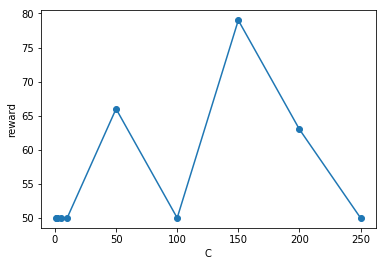

[50, 50, 50, 50, 50, 66, 50, 79, 63, 50]

In [8]:
import matplotlib.pyplot as plt

cashmoney = storerewards #[i for (i,a) in storerewards]
plt.plot(cs,cashmoney,'o-')
plt.xlabel("C")
plt.ylabel("reward")
plt.show()

storerewards

In [ ]:
# now let's compare the performance of different computation times (AND C)

storetobservations = []
storetactions = []
storetrewards = []
# times = [0.01,0.1,0.5,1.,1.5,2.0,3.0,3.5,4.0,4.5,5.0]
times = [0.5,1.,2.,5.,10.,15.,20.,30.]

for t in times:
    print("Computation time = ", t)
    
    # Initialize the tamagotchi
    realtama = Tamagotchi()
    game = Tamagotchi_Game()

    print("INITIAL STATE: ")
    realtama.print_tama() # initial tamagotchi state

    agent = POMCP(game, time = t)

    action_seq = []
    obs_seq = []
    state = tuple(realtama)
    obs = []
    context = {}

    while len(action_seq) <= 1000 and not state[2]: # play for a certain amount of time (better rule?)

        legal = game.legal_actions(state)
        action = agent.choose_move(obs,context,legal)
        action_seq.append(action)
        print("Action %i: taking action %s."% (len(action_seq),action))

        obs = game.observation(state,action)
        obs_seq.append(obs)
        if obs ==[]:
            print("No meaningful observation acquired.")
        else:
            print(obs)

        state = game.next_state(state,action)
#         if len(action_seq) % 10 == 0:
#             print("\nNumber of actions taken: ",len(action_seq))
#             r,_ = game.reward(state)
#             print("Reward so far: ",r)
#             print("Tama state:")
#             unpack(state).print_tama()

    print("game over!")
    
    storetobservations.append([obs_seq])
    storetactions.append([action_seq])
    r,_ = game.reward(state)
    storetrewards.append(r)
    unpack(state).print_tama()

Computation time =  0.5
INITIAL STATE: 
Time: 0  seconds elapsed
TAMA STATS:  {'energy': 100, 'hygiene': 100, 'happiness': 100, 'food': 100, 'health': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Action 1: taking action check-asleep.
[1, False]
Action 2: taking action check-hygiene.
['hygiene', 98.0]
Action 3: taking action check-instore.
[8, False]
Action 4: taking action check-instore.
[8, False]
Action 5: taking action check-instore.
[8, False]
Action 6: taking action check-hygiene.
['hygiene', 90.0]
Action 7: taking action check-happy.
['happiness', 88.0]
Action 8: taking action check-playing.
[3, False]
Action 9: taking action check-instore.
[8, False]
Action 10: taking action check-playing.
[3, False]
Action 11: taking action check-energy.
['energy', 80.0]
Action 12: taking action store.
No meaningful observation acquired.
Action 13: taking action check-numpoo.
[5, 0]
Action 14: taking action check-h

Action 23: taking action check-money.
[6, 10]
Action 24: taking action check-money.
[6, 10]
Action 25: taking action check-playing.
[3, False]
Action 26: taking action nothing.
No meaningful observation acquired.
Action 27: taking action check-hygiene.
['hygiene', 48.0]
Action 28: taking action store.
No meaningful observation acquired.
Action 29: taking action check-money.
[6, 10]
Action 30: taking action check-food.
['food', 58.0]
Action 31: taking action check-sick.
[4, True]
Action 32: taking action check-asleep.
[1, False]
Action 33: taking action check-happy.
['happiness', 44.0]
Action 34: taking action check-numpoo.
[5, 0]
Action 35: taking action check-asleep.
[1, False]
Action 36: taking action check-money.
[6, 10]
Action 37: taking action check-happy.
['happiness', 36.0]
Action 38: taking action check-hygiene.
['hygiene', 26.0]
Action 39: taking action check-sick.
[4, True]
Action 40: taking action snack.
No meaningful observation acquired.
Action 41: taking action check-play

Action 32: taking action check-playing.
[3, False]
Action 33: taking action check-asleep.
[1, False]
Action 34: taking action check-asleep.
[1, False]
Action 35: taking action check-instore.
[8, True]
Action 36: taking action snack.
No meaningful observation acquired.
Action 37: taking action check-health.
['health', 76.0]
Action 38: taking action nothing.
No meaningful observation acquired.
Action 39: taking action check-instore.
[8, False]
Action 40: taking action check-happy.
['happiness', 50.0]
Action 41: taking action check-energy.
['energy', 20.0]
Action 42: taking action check-playing.
[3, False]
Action 43: taking action check-money.
[6, 41]
Action 44: taking action nothing.
No meaningful observation acquired.
Action 45: taking action check-energy.
['energy', 28.0]
Action 46: taking action check-health.
['health', 58.0]
Action 47: taking action check-instore.
[8, False]
Action 48: taking action check-health.
['health', 54.0]
Action 49: taking action nothing.
No meaningful observ

Action 16: taking action check-food.
['food', 84.0]
Action 17: taking action check-energy.
['energy', 68.0]
Action 18: taking action check-food.
['food', 80.0]
Action 19: taking action check-instore.
[8, True]
Action 20: taking action check-health.
['health', 76.0]
Action 21: taking action check-playing.
[3, False]
Action 22: taking action check-instore.
[8, True]
Action 23: taking action check-numpoo.
[5, 0]
Action 24: taking action check-happy.
['happiness', 58.0]
Action 25: taking action nothing.
No meaningful observation acquired.
Action 26: taking action play.
No meaningful observation acquired.
Action 27: taking action store.
No meaningful observation acquired.
Action 28: taking action check-food.
['food', 60.0]
Action 29: taking action nothing.
No meaningful observation acquired.
Action 30: taking action play.
No meaningful observation acquired.
Action 31: taking action store.
No meaningful observation acquired.
Action 32: taking action snack.
No meaningful observation acquired.

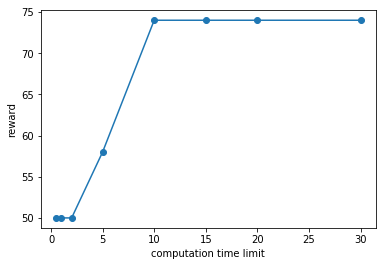

In [11]:
# times = [0.01,0.1,0.5,1.,1.5,2.0,3.0,3.5,4.0,4.5,5.0]
cashtmoney = storetrewards #[50, 50, 54, 50, 54, 74, 50, 74, 50, 50, 50] #[i for (i,a) in storetrewards]
plt.plot(times,cashtmoney,'o-')
# plt.title("POMCP performance versus computation")
plt.xlabel("computation time limit")
plt.ylabel("reward")
plt.show()

In [33]:
storetrewards

[50, 50, 54, 50, 54, 74, 50, 74, 50, 50, 50]

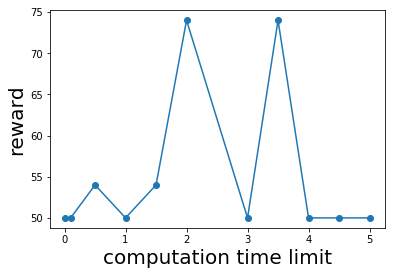

In [3]:
smalltimes = [0.01,0.1,0.5,1.,1.5,2.0,3.0,3.5,4.0,4.5,5.0]
cashtmoney = [50, 50, 54, 50, 54, 74, 50, 74, 50, 50, 50] #[i for (i,a) in storetrewards]
plt.plot(smalltimes,cashtmoney,'o-')
# plt.title("POMCP performance versus computation")
plt.xlabel("computation time limit",fontsize=20)
plt.ylabel("reward",fontsize=20)
plt.show()